In [1]:
# import sys
# !{sys.executable} -m pip install librosa
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import time
import collections
import pickle

In [2]:
# Read Data
data = pd.read_csv('speech_accent/speakers_all.csv')

data = data[data['file_missing?'] != True]
data = data[data['filename'] != 'nicaragua']
data = data[data['filename'] != 'sinhalese1']
data.head(10)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,NaN,NaN,NaN
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,NaN,NaN,NaN
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,NaN,NaN,NaN
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,NaN,NaN,NaN
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,NaN,NaN,NaN
37,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,3,ivory coast,False,NaN,NaN,NaN
38,41.0,5.0,"accra, ghana",akan1,akan,male,979,ghana,False,NaN,NaN,NaN
39,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,4,kosovo,False,NaN,NaN,NaN
40,33.0,15.0,"tirana, albania",albanian2,albanian,male,5,albania,False,NaN,NaN,NaN
41,44.0,35.0,"tirana, albania",albanian3,albanian,male,458,albania,False,NaN,NaN,NaN


In [3]:
# remove last 3 unknown columns
data = data.iloc[:,:-3]

# find out how many time each language appear in this dataset
language_freq = collections.Counter(data['native_language'])
frequency = []
for i in data['native_language']:
    frequency.append(language_freq[i])

data['frequency'] = frequency

# add column: file path
data['filePath'] = 'speech_accent/recordings/' + data['filename'] + '.wav'

data.head(10)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,frequency,filePath
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,5,speech_accent/recordings/afrikaans1.wav
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,5,speech_accent/recordings/afrikaans2.wav
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,5,speech_accent/recordings/afrikaans3.wav
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,5,speech_accent/recordings/afrikaans4.wav
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,5,speech_accent/recordings/afrikaans5.wav
37,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,3,ivory coast,False,1,speech_accent/recordings/agni1.wav
38,41.0,5.0,"accra, ghana",akan1,akan,male,979,ghana,False,1,speech_accent/recordings/akan1.wav
39,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,4,kosovo,False,9,speech_accent/recordings/albanian1.wav
40,33.0,15.0,"tirana, albania",albanian2,albanian,male,5,albania,False,9,speech_accent/recordings/albanian2.wav
41,44.0,35.0,"tirana, albania",albanian3,albanian,male,458,albania,False,9,speech_accent/recordings/albanian3.wav


In [4]:
data.shape

(2138, 11)

In [5]:
# remove rows that the language appears less than 3 time in this dataset.
data = data[data['frequency'] > 19]

# find out how many unique countries in the dataset
uniLanguage = data['native_language'].unique().tolist()
numOfLanguage = len(uniLanguage)
print("number of unique languages:", numOfLanguage)

# convert Languages name to number 0 - 35
languageCode = []
for i in data['native_language']:
    languageCode.append(uniLanguage.index(i))
    
data['languageCode'] = languageCode

data.head()

number of unique languages: 21


,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,frequency,filePath,languageCode
50,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False,20,speech_accent/recordings/amharic1.wav,0
51,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,False,20,speech_accent/recordings/amharic10.wav,0
52,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,False,20,speech_accent/recordings/amharic11.wav,0
53,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,False,20,speech_accent/recordings/amharic12.wav,0
54,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,False,20,speech_accent/recordings/amharic13.wav,0


In [6]:
data.shape

(1487, 12)

In [7]:
uniLanguage

['amharic',
 'arabic',
 'cantonese',
 'dutch',
 'english',
 'farsi',
 'french',
 'german',
 'italian',
 'japanese',
 'korean',
 'macedonian',
 'mandarin',
 'polish',
 'portuguese',
 'romanian',
 'russian',
 'spanish',
 'swedish',
 'turkish',
 'vietnamese']

size of spectrogram: (128, 646)


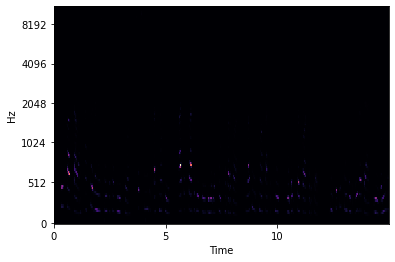

In [8]:
# default duration = 2.97
duration_time = 15

# Example of a Siren spectrogram
y, sr = librosa.load('speech_accent/recordings/english21.wav', duration=duration_time) # can adjust duration, shape change
ps = librosa.feature.melspectrogram(y=y, sr=sr)

print("size of spectrogram:",ps.shape)

librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [9]:
# how long the sound we use, determine by above duration_time, 2.97 = 128; 11.88 = 512
# replace all (128,128) to (128,length) which dynamically set up the network parameter. 
length = ps.shape[1]

# get the total sample size of new dataset (after removal)
numOfTotal = data.shape[0]

# subset of data, for testing (how many samples from dataset we use)
numOfSample = numOfTotal #1000
#numOfSample = 100
data = data[:numOfSample]
print("dataset dimension:",data.shape)
print("number of samples:", numOfSample)
print("number of native languages:", numOfLanguage)

dataset dimension: (1487, 12)
number of samples: 1487
number of native languages: 21


In [85]:
# generating spectrogram matrix from each sound file

D = [] # Dataset

start = time.time()

for row in data.itertuples():
    y, sr = librosa.load(row.filePath, duration=duration_time)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, length): continue
    D.append( (ps, row.languageCode) )

end = time.time()    

print("Number of samples: ", len(D))
print("time used for generating spectrogram:", end-start)

Number of samples:  1487
time used for generating spectrogram: 998.1196880340576


In [60]:
# If you load spectrogram dataframe from file, no need to run above cell code

open_file = open('spectrogram_language', "rb")
D = pickle.load(open_file)
open_file.close()

In [61]:
dataset = D

# radomize the dataset
random.shuffle(dataset)

numSplit = round(numOfSample * 0.8)

# split training set and testing set
train = dataset[:numSplit]
test = dataset[numSplit:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, length, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, length, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, numOfLanguage))
y_test = np.array(keras.utils.to_categorical(y_test, numOfLanguage))

In [62]:
# set up neural network: layer, number of neuron, activation function, etc.
model = Sequential()
input_shape=(128, length, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 3), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 3), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

# output layer, "numOfLanguage" is 0-35 which represent which language been classified 
model.add(Dense(numOfLanguage))
model.add(Activation('softmax'))

In [63]:
# start training time
start = time.time()

# build up the network and train
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

# use trainset to train the network
model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_test, y_test))

# end training time
end = time.time()

# use testset to test the network 
score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("time used for trainning:", end - start)

Epoch 1/12
11/11 [==============================] - 50s 5s/step - loss: 5.4699 - accuracy: 0.1304 - val_loss: 3.3007 - val_accuracy: 0.2760
Epoch 2/12
11/11 [==============================] - 46s 4s/step - loss: 3.3654 - accuracy: 0.2133 - val_loss: 3.1048 - val_accuracy: 0.3620
Epoch 3/12
11/11 [==============================] - 47s 4s/step - loss: 3.1476 - accuracy: 0.3030 - val_loss: 3.0249 - val_accuracy: 0.3620
Epoch 4/12
11/11 [==============================] - 47s 4s/step - loss: 2.9820 - accuracy: 0.3244 - val_loss: 2.8795 - val_accuracy: 0.3620
Epoch 5/12
11/11 [==============================] - 47s 4s/step - loss: 2.8149 - accuracy: 0.3296 - val_loss: 2.9064 - val_accuracy: 0.3650
Epoch 6/12
11/11 [==============================] - 48s 4s/step - loss: 2.6515 - accuracy: 0.3467 - val_loss: 2.9210 - val_accuracy: 0.3561
Epoch 7/12
11/11 [==============================] - 47s 4s/step - loss: 2.5343 - accuracy: 0.3622 - val_loss: 2.9381 - val_accuracy: 0.3620
Epoch 8/12
11/11 [==

In [10]:
# use 1487 samples to classify 21 different languages, we get ~0.34 accuracy, which is better than classify countries.